# `dPdI.ipynb`

Procedure/notes/code for conversion from current noise A^2/Hz to power W^2/Hz following `QETpy` procedures

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import picoscopedata
import warnings
warnings.filterwarnings('ignore')
import importlib

import sys
sys.path.append('../qetpy')
import qetpy as qp

In [270]:
importlib.reload(picoscopedata)
#pd.read_csv('./ibis_data/20240924-0001_3.csv', skiprows=(1,2))

ibis = picoscopedata.PicoscopeData('20240924-0001', data_dir = './ibis_data', idx = range(1,4))

#ibis('H').shape, ibis.ts.shape

ts_untouched = picoscopedata.PicoscopeData('20240924-0001', data_dir = './ibis_data', idx = range(1,4), shift_times = False).ts

waveform = ibis('H')


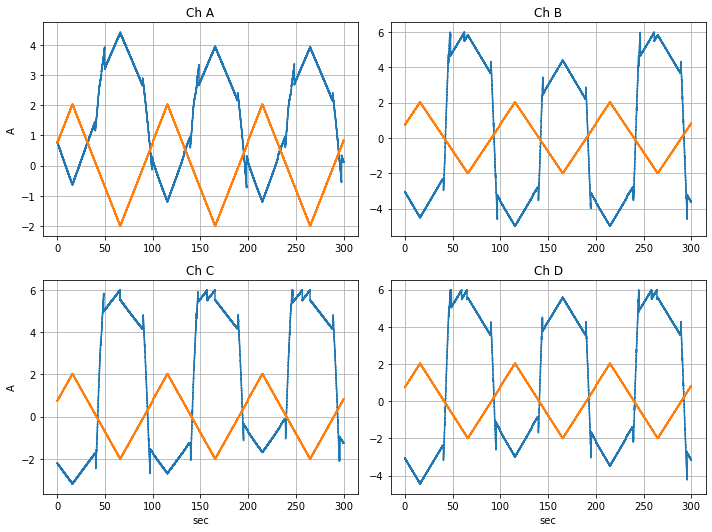

In [202]:
# plot IBIS data

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

fig.suptitle('IbIs data')

for ax in axs[1]:
    ax.set_xlabel('sec')
for ax in axs[:,0]:
    ax.set_ylabel('A')

for i, c, ax in zip(range(4), 'ABCD', axs.flatten()):

    ax.grid()

    ax.plot(ibis.ts, ibis(c))
    ax.plot(ibis.ts, waveform)
    ax.set_title(f'Ch {c}')

fig.tight_layout()


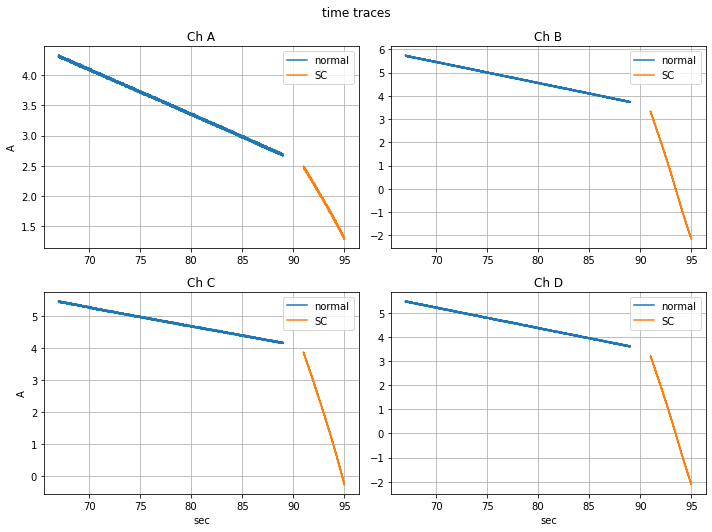

In [203]:
# normal/SC limits on IBIS data
n_lims = np.array([67_000, 89_000])
sc_lims = np.array([91_000, 95_000])
all_lims = np.hstack((n_lims, sc_lims))

normalinds = range(*n_lims)
scinds = range(*sc_lims)
full_sweep = range(all_lims.min(), all_lims.max())

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

fig.suptitle('time traces')

for ax in axs[1]:
    ax.set_xlabel('sec')
for ax in axs[:,0]:
    ax.set_ylabel('A')

for i, c, ax in zip(range(4), 'ABCD', axs.flatten()):

    ax.grid()
    ax.set_title(f'Ch {c}')


    ax.plot(ibis.ts[normalinds], ibis(c)[normalinds], label = 'normal')
    ax.plot(ibis.ts[scinds], ibis(c)[scinds], label = 'SC')

    ax.legend()

    #ax.plot(ibis(c)[nslice])
    #ax.plot(ibis(c)[scslice])


    wind = ax.axis()

    #ax.plot(ibis.ts, ibis(c))

    ax.axis(wind)
    

fig.tight_layout()


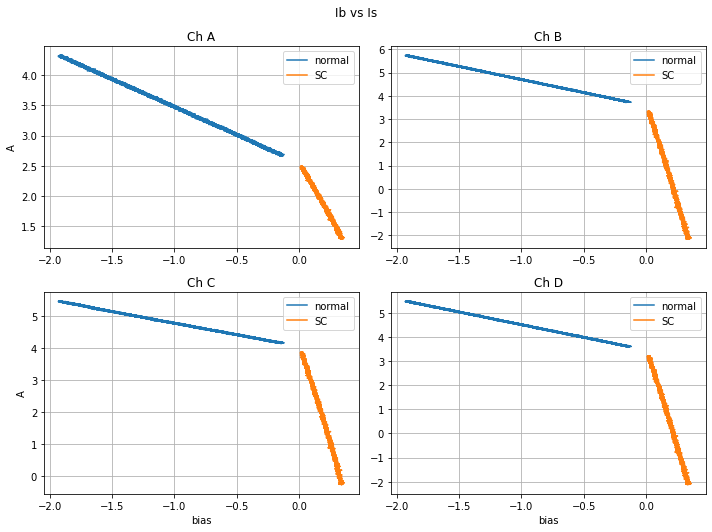

In [204]:
# normal/SC limits on IBIS data

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

fig.suptitle('Ib vs Is')

for ax in axs[1]:
    ax.set_xlabel('bias')
for ax in axs[:,0]:
    ax.set_ylabel('A')

for i, c, ax in zip(range(4), 'ABCD', axs.flatten()):

    ax.grid()
    ax.set_title(f'Ch {c}')


    ax.plot(ibis('H')[normalinds], ibis(c)[normalinds], label = 'normal')
    ax.plot(ibis('H')[scinds], ibis(c)[scinds], label = 'SC')

    ax.legend()

    #ax.plot(ibis(c)[nslice])
    #ax.plot(ibis(c)[scslice])


    wind = ax.axis()

    #ax.plot(ibis.ts, ibis(c))

    ax.axis(wind)
    

fig.tight_layout()


In [205]:
channels = 'ABCD'

pscope_digitizer_err = 0.01#20/(2**12)

ibias = np.stack(4*[ibis('H')])[np.newaxis,:]

dites = np.array([ibis(c)/(-10.) for c in channels])[np.newaxis,:]

ivfits = qp.IBIS(
    dites = dites, 
    ibias = ibias, 
    rsh = ibis.config['rsh'], 
    rsh_err = ibis.config['rsh']/100, 
    normalinds = normalinds, 
    scinds = scinds, 
    fitsc = True,
    chan_names = [c for c in channels],
    dites_err = np.full(ibias.shape, pscope_digitizer_err),
    ibias_err = np.full(ibias.shape, pscope_digitizer_err),
    )

ivfits.analyze()

In [206]:
ivfits.rnorm

array([[0.16171825, 0.16643119, 0.2581448 , 0.17818628]])

In [208]:
ivfits.rp

array([[ 0.03499064, -0.00836245, -0.00418476, -0.00795998]])

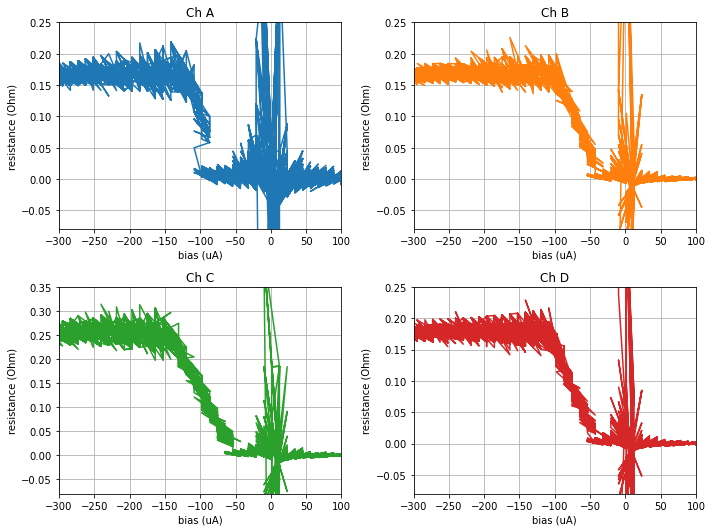

In [216]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

for i, (c,ax) in enumerate(zip(channels, axs.flatten())):
    ax.grid()
    ax.set_title(f'Ch {c}')
    ax.plot(ibis('H')[full_sweep]*1e3, ivfits.r0[0,i][full_sweep], label = c, color = f'C{i}')
    ax.set_ylim(-0.08, 0.35 if c == 'C' else 0.25)
    ax.set_xlim(-300, 100)
    ax.set_xlabel('bias (uA)')
    ax.set_ylabel('resistance (Ohm)')

#plt.legend(loc = 'best')
fig.tight_layout()

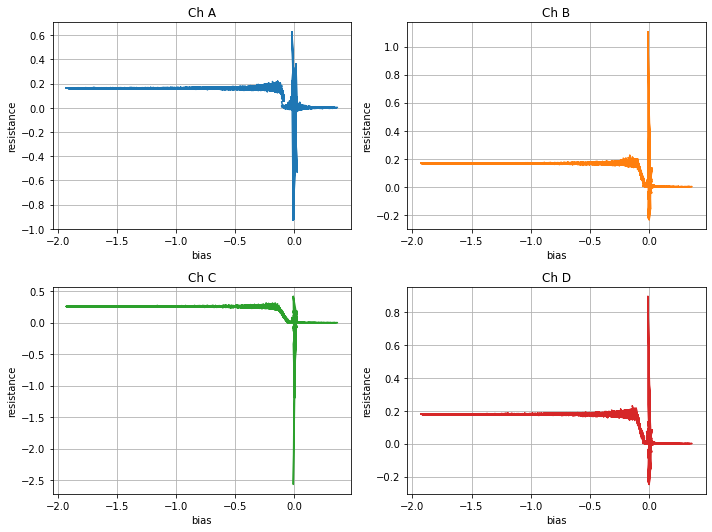

In [217]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

for i, (c,ax) in enumerate(zip(channels, axs.flatten())):
    ax.grid()
    ax.set_title(f'Ch {c}')
    ax.plot(ibis('H')[full_sweep], ivfits.r0[0,i][full_sweep], label = c, color = f'C{i}')
    #ax.set_ylim(-0.1, 0.1)
    ax.set_xlabel('bias')
    ax.set_ylabel('resistance')

#plt.legend(loc = 'best')
fig.tight_layout()

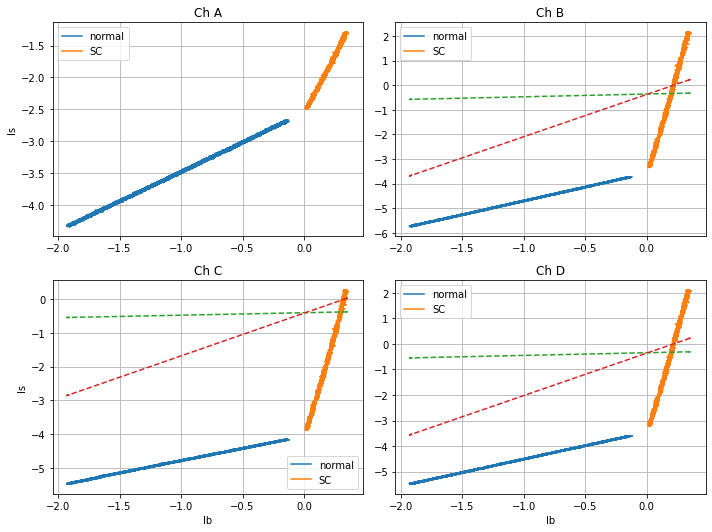

In [218]:

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

for ax in axs[1]:
    ax.set_xlabel('Ib')
for ax in axs[:,0]:
    ax.set_ylabel('Is')

for i, c, ax in zip(range(4), 'ABCD', axs.flatten()):

    ax.grid()
    ax.set_title(f'Ch {c}')


    ax.plot(ibis('H')[normalinds], -ibis(c)[normalinds], label = 'normal')
    ax.plot(ibis('H')[scinds], -ibis(c)[scinds], label = 'SC')

    wind = ax.axis()

    ax.legend()

    ax.plot(ibis('H')[full_sweep], ivfits.int_n[0,i,0] + ivfits.slope_n[0,i,0]*ibis('H')[full_sweep], '--')
    ax.plot(ibis('H')[full_sweep], ivfits.int_sc[0,i,0] + ivfits.slope_sc[0,i,0]*ibis('H')[full_sweep], '--')


    ax.axis(wind)

    #ax.plot(ibis(c)[nslice])
    #ax.plot(ibis(c)[scslice])


    wind = ax.axis()

    #ax.plot(ibis.ts, ibis(c))

    ax.axis(wind)
    

fig.tight_layout()


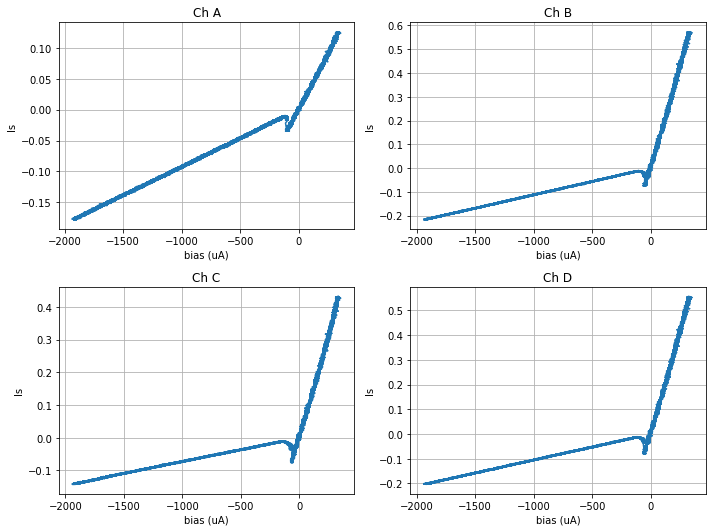

In [222]:

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))


for i, c, ax in zip(range(4), 'ABCD', axs.flatten()):

    ax.grid()
    ax.set_title(f'Ch {c}')
    ax.set_xlabel('bias (uA)')
    ax.set_ylabel('Is')


    #ax.plot(ibis('H')[normalinds], -ibis(c)[normalinds], label = 'normal')
    #ax.plot(ibis('H')[scinds], -ibis(c)[scinds], label = 'SC')
    ax.plot(ivfits.ibias_true[0,i][full_sweep]*1e3, ivfits.ites[0,i][full_sweep])

    wind = ax.axis()

    #ax.legend()

    #ax.plot(ibis('H')[full_sweep], ivfits.int_n[0,i,0] + ivfits.slope_n[0,i,0]*ibis('H')[full_sweep], '--')
    #ax.plot(ibis('H')[full_sweep], ivfits.int_sc[0,i,0] + ivfits.slope_sc[0,i,0]*ibis('H')[full_sweep], '--')


    ax.axis(wind)

    #ax.plot(ibis(c)[nslice])
    #ax.plot(ibis(c)[scslice])


    wind = ax.axis()

    #ax.plot(ibis.ts, ibis(c))

    ax.axis(wind)
    

fig.tight_layout()


In [311]:
# config dict

didv = picoscopedata.PicoscopeData('20240924-0001', './didv_data', 2, shift_times = False)
didv1 = picoscopedata.PicoscopeData('20240924-0001', './didv_data', 1, shift_times = False)

__didv_config = {
    'series_name': 'test_fakedata_1',
    'group_name': 'fakes',
    'fs': (1/np.diff(didv.ts)).mean(), # sample rate (Hz)
    'output_variable_gain': 50., # output gain
    #'output_variable_offset': 0., # voltage offset (so, DC component I think?) (V)
    #'close_loop_norm': 625_000., # idk
    'rshunt': didv.config['rsh'], # shunt resistance (Ohms)
    #'rp': 0.001, # estimated parasitic resistance of non-shunt side of TES circuit (Ohms)
    #'tes_bias': 0.000005, # bias?
    'sgfreq': 500., # frequency of signal generator (Hz)
    'sgamp': 0.5e-3, # peak-to-peak size of square wave from signal generator (A)
}

__didv_config = pd.Series(__didv_config)

__didv_config

series_name             test_fakedata_1
group_name                        fakes
fs                        100000.002519
output_variable_gain               50.0
rshunt                             0.02
sgfreq                            500.0
sgamp                            0.0005
dtype: object

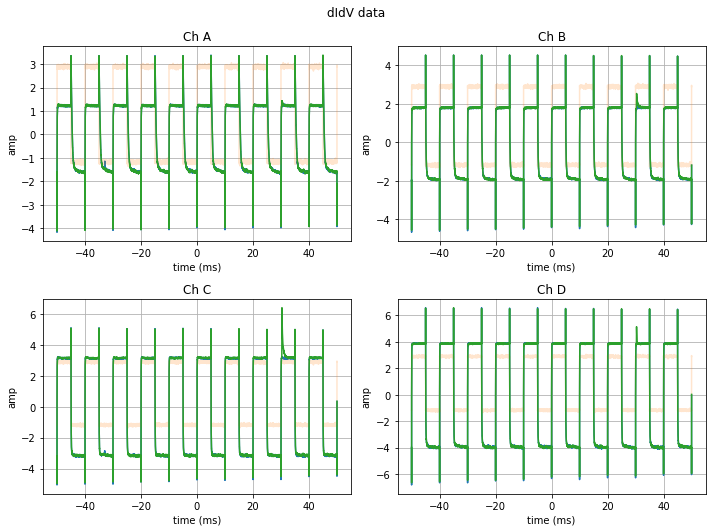

In [312]:
# plot IBIS data

didv_waveform = didv('H')

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

fig.suptitle('dIdV data')


for i, c, ax in zip(range(4), 'ABCD', axs.flatten()):

    ax.grid()
    ax.set_ylabel('amp')
    ax.set_xlabel('time (ms)')
    ax.set_title(f'Ch {c}')

    ax.plot(didv.ts*1e3, didv(c))
    ax.plot(didv.ts*1e3, didv('H')/10, alpha = 0.2)
    #ax.plot(didv1.ts*1e3, didv1(c))

fig.tight_layout()


In [276]:
np.round(1/(np.diff(didv.ts)).mean())

100000.0

In [277]:
ivfits.r0[0,2][normalinds].mean()

0.2578238339137044

In [304]:
ff = np.round(1/((np.diff(didv.ts)).mean()))
freq = 100

ff, freq, ff/freq, didv.ts.size/10

(100000.0, 100, 1000.0, 1000.4)

In [334]:
didvfit = {}

for i, c in enumerate('ABCD'):
    didvfit[c] = qp.DIDV(
        rawtraces = np.array([didv(c), didv1(c)]),
        fs = np.round(1/((np.diff(didv.ts)).mean())),
        sgfreq = didv.config['freq'],
        sgamp = didv.config['amp'],
        rsh = didv.config['rsh'],
        rp = ivfits.rp[0],
        dutycycle = 0.5,
        add180phase = False,
        #autoresample = True,
        r0 = ivfits.r0[0,i][normalinds].mean(), # estimated TES resistance (Ohms)
        tracegain = (50)*(10)*(2)*(1.2e3), # what to divide by to convert rawtraces to Amps (from convert_ADC)
        dt0 = -1e-6 # guess
        )

    didvfit[c].processtraces()

In [335]:
# fit 
for c in 'ABCD':
    didvfit[c].dofit(2) # Two poles fit
    didvfit[c].dofit(3) # Tree poles fit


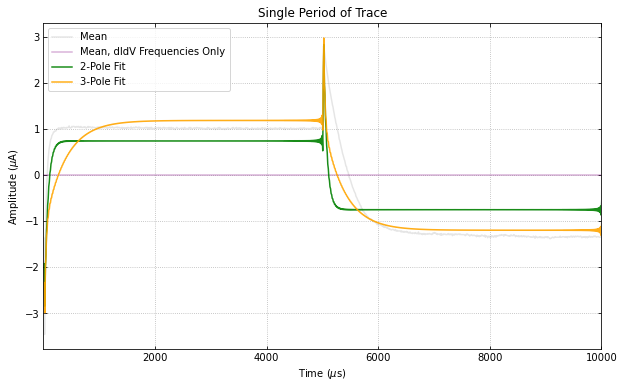

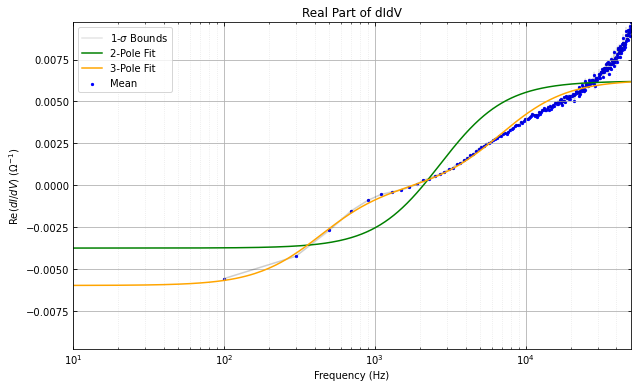

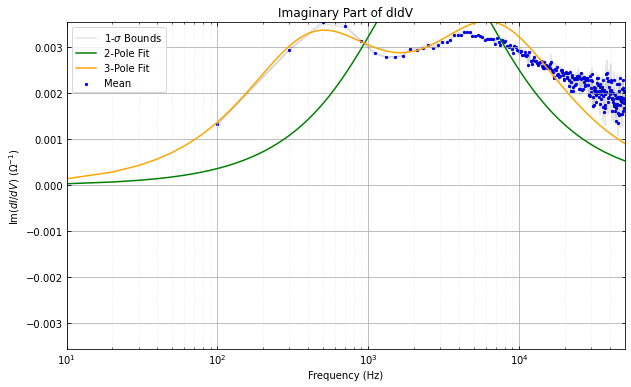

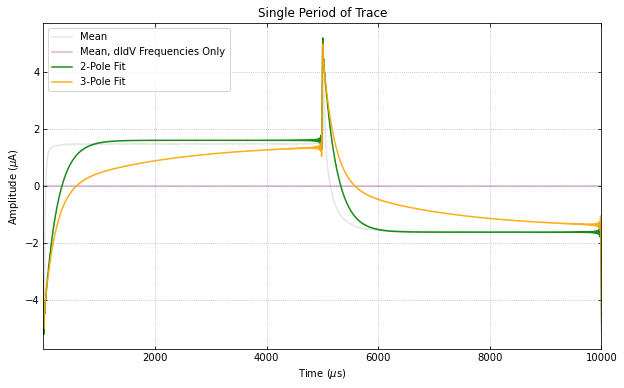

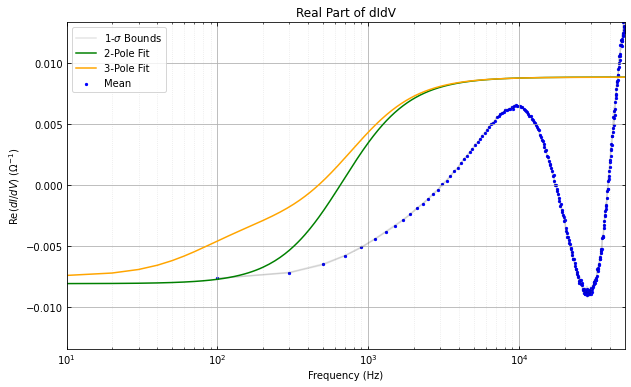

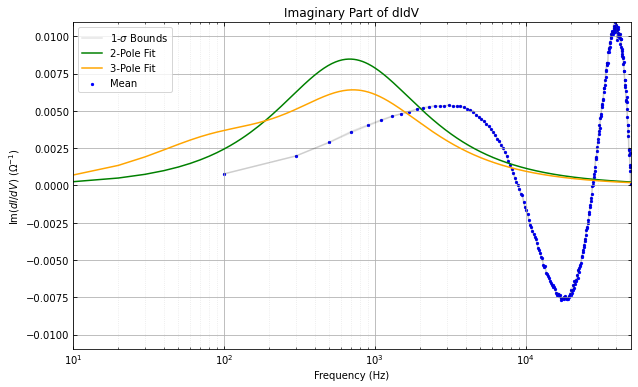

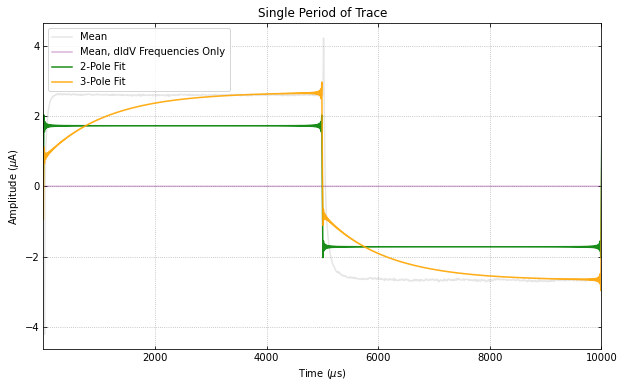

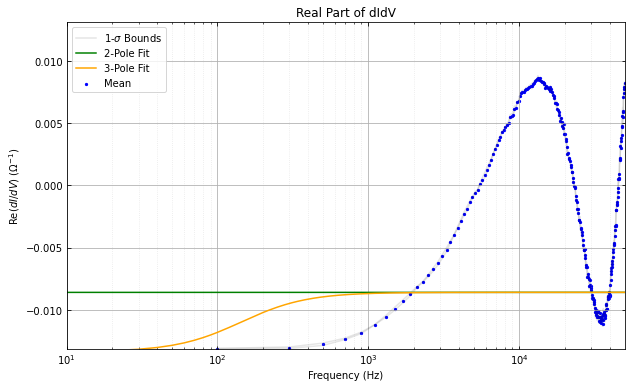

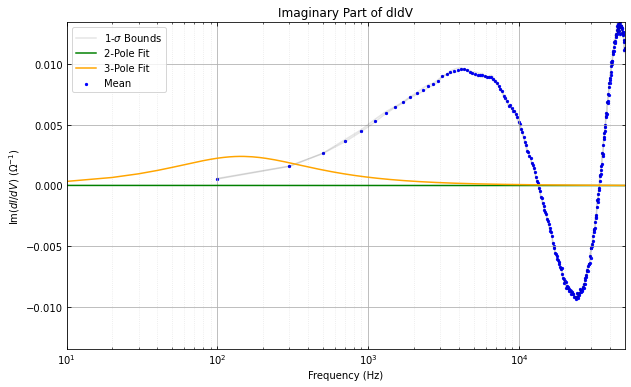

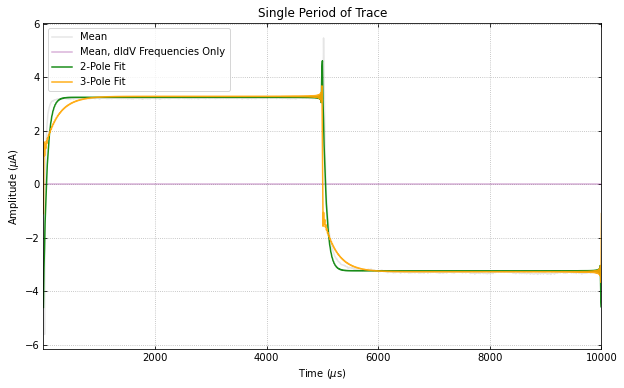

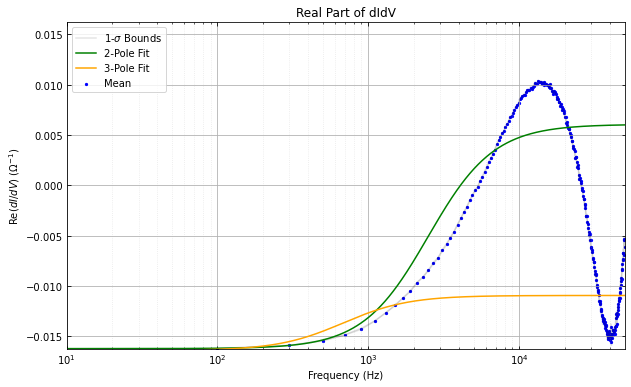

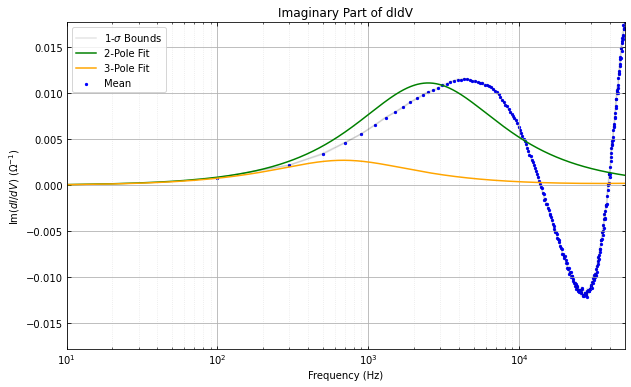

In [336]:
# display
for c in 'ABCD':
    didvfit[c].plot_single_period_of_trace(didv_freq_filt=True)
    didvfit[c].plot_re_im_didv()

In [337]:
# IBIS object can take multiple bias points (iters), channels (chs), and different temperatures (temps)
# input array dites has shape either (niters,), (nch,niters), or (ntemps,nch,niters)
# bias vals given in ibias (should be increasing along "iters" dimension)

# read dites/ibias data from csv
#ivdf = pd.read_csv('IV.csv', index_col = 0)

#chan_names = list(ivdf.columns)
#ibias = np.expand_dims(np.stack(len(chan_names)*[ivdf.index.values]), axis = 0)
#ibias = np.stack(len(chan_names)*[ivdf.index.values], axis = 0)[np.newaxis,:]
#dites = np.array([ivdf[c].values for c in chan_names])[np.newaxis,:]

# create IBIS object
#ivdata = qp.IBIS(
#    dites = dites, # read out current from electronics (A)
#    dites_err = np.zeros(dites.shape), 
#    ibias = ibias, # TES bias current for dites measurements (A)
#    ibias_err = np.zeros(ibias.shape),
#    rsh = didv.config['rsh'], # shunt resistance of TES circuit
#    rsh_err = 0.,
#    normalinds = np.array([0,1,2]), # indices of normal resistance points in dites (will do separate normal and SC fits)
#    #rp_guess = ,
#    #rp_err_guess = ,
#    chan_names = chan_names
#)

#ivdata.analyze()
# then e.g. grab ivdata.r0 for r0 in dict below

# IBIS objects fit (Ib,Is) data (aka (ibias/dites)) to lines of the form
# Is = A*Ib + B

# ivdata.rp = parasitic resistance in TES line
# ivdata.rnorm = normal-state resistance of TES
# ivdata.rfit = total resistance rnorm + rp + Rs
# ivdata.r0 = equiv to rnorm, but accounting for shift of the "baseline" point of the normal-mode Ib/Is line (so looking at (dites - ioff) = (rsh/(rsh+rp+r0))(ibias - ibias_off) ) '
# ---> (Is - Is0) = (Rs/(Rs+Rp+Rn))(Ib - Ib0)
# ivdata.ioff = TES current offset - point where SC and normal mode lines intersect (y-coord)
# ivdata.ibias_off = bias current offset - point where SC and normal mode lines intersect (x-coord)
# ites = dites - ioff
# ibias_true = ibias - ibias_off

In [338]:
# condense info from IbIs (and other sources) into dict
# (this dict from didv demo notebook)
ivsweep_results = {
    'close_loop_norm': 625000.0, # idk (see above)
    'group_name_sweep': 'iv_didv_I2_D20230923_T131239',
    'i0': 1.2510621880090041e-07, # ?? from Irwin chapter the "steady state" current given as I0 (A) (maybe ites?)
    # maybe baseline current outside of square wave amplitude?
    'i0_err': 8.342312444985714e-12,
    'i0_off': 3.89669341000469e-09, # ioff from DIDV? - the current offset (A)
    'i0_off_err': 5.507092047349402e-12,
    'i0_variable_offset': -9.865689873695374e-06, # ??
    'ibias': 4.5126593406593545e-06, # applied QET bias current (A) (ibias)
    'ibias_off': -3.381406772500224e-08, # current offset of the QET bias (A)
    'ibias_off_err': 1.0347074588426951e-11,
    'lgc_invert_offset': True, 
    'output_variable_gain': 50.0, # see above
    'output_variable_offset': -0.12332112342119217, # see above
    'p0': 2.7194163442462373e-15, # power of TES (W)?
    'p0_err': 5.532206867147335e-17,
    'r0': 0.1737472370023056, # TES resistance (Ohms)?
    'r0_err': 0.003534606260879604,
    'rn': 0.8713947570750865, # normal-state resistance (Ohms) ?
    'rn_err': 0.017587140432555274, 
    'rp': 0.0029572918826476936, # parasitic resistance in non-shunt side of TES circuit (see above) (Ohms)
    'rp_err': 5.9145837652953874e-05,
    'rshunt': 0.004999999888241291, # shunt resistance (Ohms)
    'rshunt_err': 9.999999776482583e-05
    }

# "required params" ['rp', 'i0', 'i0_err','r0', 'r0_err']

In [339]:
# ibis notes:
# triangle wave
# 0.1 Hz
# 2 V
# set QET biases to zero
# gain 1

# didv notes:
# square wave
# 100 Hz
# 20 m
# gain 50

# offx - QET bias in V

In [340]:
# dict used to calculate small signal params
didvfit.calc_smallsignal_params(ivsweep_results)

AttributeError: 'dict' object has no attribute 'calc_smallsignal_params'

In [ ]:
# printing out results
results = didvfit.fitresult()
data = {'Model':['2-pole', '3-pole'],
        'Tau1 [usec]': ['{:.3g}'.format(1e6*np.abs(results[2]['params']['tau1'])),
                        '{:.3g}'.format(1e6*np.abs(results[3]['params']['tau1']))],
        'Tau2 [usec]': ['{:.3g}'.format(1e6*results[2]['params']['tau2']),
                        '{:.3g}'.format(1e6*results[3]['params']['tau2'])],
        'Tau3 [usec]': ['{:.3g}'.format(1e6*results[2]['params']['tau3']),
                        '{:.3g}'.format(1e6*results[3]['params']['tau3'])]}
        
        
    
# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print('Fit time constants, NOT dIdV Poles: ')
display(df.style.hide_index())    
        
data = {'Model':['2-pole', '3-pole'],
        'Tau+[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][0]),
                       '{:.3g}'.format(1e6*results[3]['falltimes'][0])],
        'Tau-[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][1]),
                       '{:.3g}'.format(1e6*results[3]['falltimes'][1])],
        'Tau3[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][2]),
                       '{:.3g}'.format(1e6*results[3]['falltimes'][2])]}
# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print('\nTrue dIdV Poles: ')
display(df.style.hide_index()) 

In [ ]:
# load psd data (A^2/Hz) (folded is fine)
npsd = 10_000
psd_freqs = np.linspace(1e-4, 100, npsd) # Hz
psd = 1/(12.5 + psd_freqs) # A^2/Hz

In [ ]:
# calculate dPdI and noise power in two steps
dpdi, dpdi_err = qp.get_dPdI_with_uncertainties(psd_freqs, results[3], lgcplot=False)

noise_power = psd*abs(dpdi)**2

In [ ]:
# calculate dpdi and noise power in one step (don't trust this method)

noise_power_folded, noise_power_folded_err = qp.get_power_noise_with_uncertainties(psd_freqs, psd, results[3], lgcplots=False, lgcdpdireturn=False)

In [ ]:

plt.plot(psd_freqs, noise_power)
#plt.plot(psd_freqs, noise_power_folded)